<font size="5">__cta-lstchain: Notebook for testing the effects of impact parameters on the energy reconstruction__</font>
    
<font size="4">
To run this notebook you will need the last version of cta-lstchain:

git clone https://github.com/cta-observatory/cta-lstchain
<br>
<br>
**If you have ctapipe already installed in a conda environment:**
<br><br>
source activate cta-dev
<br>
python setup.py install
<br>
<font size="4">
**If you don't have ctapipe installed:**</font>
<br><br>
conda env create -f environment.yml
<br>
source activate cta-dev
<br>
python setup.py install

Also, you will need the datafiles from **cta-lstchain-extra:**

git clone https://github.com/cta-observatory/cta-lstchain-extra

**Content:**
- Definition of two functions for presenting the energy resolution:
    - plot_e_resolution: For plotting the STD and Bias of Erec-Etrue in several energy bins.
    - calc_resolution: For calculating the overall energy resolution in terms of the 68% area.
- Plotting energy vs. intensity to check linearity.
- Training RF without cuts in Impact Parameter.
- Taining RF only with events with Impact Parameter between 40 m and 100 m.
- Training RF witg all events, but including Impact Parameter as a feature.



<font size="4">
**Some imports...**

In [1]:
import numpy as np                                                                                            
import pandas as pd                                                                                                                                                                                      
import matplotlib.pyplot as plt                                                                                                                                                             
from lstchain.reco import dl1_to_dl2     
from lstchain.visualization import plot_dl2                                                                   
from lstchain.reco import utils
import scipy
from matplotlib import gridspec 
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 14

/Users/garciaenrique/anaconda3/envs/cta-dev/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


<font size="4">
**Define two functions to show results later**

In [2]:
def plot_e_resolution(data,Nbins):
    plt.rcParams['figure.figsize'] = (30, 10)
    plt.rcParams['font.size'] = 14

    #difE = ((data['mc_energy']-data['reco_energy'])*np.log(10))
    difE = np.log(10**data['reco_energy']/10**data['mc_energy'])
    means_result = scipy.stats.binned_statistic(                                                                                                        
            data['mc_energy'],[difE,difE**2],                                                                                                             
            bins=Nbins,range=(1,6),statistic='mean')                                                                                                           
    means, means2 = means_result.statistic                                                                                                              
    standard_deviations = np.sqrt(means2 - means**2)                                                                                                    
    bin_edges = means_result.bin_edges                                                                                                                  
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.

    gs0 = gridspec.GridSpec(1,2,width_ratios=[1,2])
    subplot = plt.subplot(gs0[0])
    gs = gridspec.GridSpecFromSubplotSpec(2, 1,height_ratios=[1, 1],subplot_spec=subplot)

    ax0 = plt.subplot(gs[0])                                                                                                                            
    plot0 = ax0.errorbar(x=bin_centers, y=means, yerr=standard_deviations,linestyle='none', marker='.')

    plt.ylabel('Bias',fontsize=24)
    plt.grid()
    ax1 = plt.subplot(gs[1],sharex = ax0)                                                                                                              
    plot1 = ax1.plot(bin_centers,standard_deviations,                                                                                                   
                     marker='+',linestyle='None')
    plt.ylabel('STD',fontsize=24)
    plt.xlabel('$log_{10}E_{true}(GeV)$',fontsize=24)
    plt.grid()

    subplot2 = plt.subplot(gs0[1])
    
    #Lines for setting the configuration of the subplots depending on Nbins
    import math
    sqrtNbins = np.sqrt(Nbins)
    a = int(math.ceil(sqrtNbins))
    dif = a - sqrtNbins
    b=a
    if dif > 0.5:
        b=a-1
        
    gs2 = gridspec.GridSpecFromSubplotSpec(a, b,subplot_spec=subplot2)
    for nbin in range(0,Nbins):
        ax = plt.subplot(gs2[nbin])
        plt.hist(difE[means_result.binnumber==nbin+1],50,label='$logE_{center}$ '+'%.2f' % bin_centers[nbin])
        plt.legend()
    plt.subplots_adjust(hspace=.25)
    plt.subplots_adjust(wspace=.5)

In [3]:
def calc_resolution(data):
    difE = np.log(10**data['reco_energy']/10**data['mc_energy'])
    n , bins, _ = plt.hist(difE,bins=500)
    mu,sigma = scipy.stats.norm.fit(difE)
    print(mu,sigma)
    bin_width = bins[1] - bins[0]
    total = bin_width*sum(n)*0.68
    idx = np.abs(bins - mu).argmin()
    x = 0
    mindif = 1e10
    xpos=0
    integral=0
    while integral <= total: 
        integral = bin_width*sum(n[idx-x:idx+x])
        x = x+1
    print(x,integral,total)
    sigma = bins[idx+x-1]
    plt.plot(bins,integral*scipy.stats.norm.pdf(bins, mu, sigma),linewidth=4,color='red',linestyle='--')
    plt.xlabel("$log(E_{rec}/E_{true})$")
    print(mu,sigma)
    return mu,sigma

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

<font size="4">
**Get event DL1 file for training.**
<br>
Gammas are pointlike.

In [5]:
PATH_EVENTS = "../../cta-lstchain-extra/reco/sample_data/dl1/"
gammafile = PATH_EVENTS+"/gamma_events_point_tiny.h5"
df_gammas = pd.read_hdf(gammafile) 

<font size="4">
We read the file as pandas dataframes:

In [6]:
df_gammas.keys()

Index(['obs_id', 'event_id', 'mc_energy', 'mc_alt', 'mc_az', 'mc_core_x',
       'mc_core_y', 'mc_h_first_int', 'mc_type', 'gps_time', 'width', 'length',
       'wl', 'phi', 'psi', 'r', 'x', 'y', 'intensity', 'skewness', 'kurtosis',
       'mc_alt_tel', 'mc_az_tel', 'impact', 'mc_x_max', 'time_gradient',
       'intercept', 'src_x', 'src_y', 'disp', 'hadroness', 'disp_norm'],
      dtype='object')

<font size="4">
We can keep only bright showers:

In [7]:
df_gammas = df_gammas[df_gammas['intensity']>np.log10(300)]
df_gammas.describe()

,obs_id,event_id,mc_energy,mc_alt,mc_az,mc_core_x,mc_core_y,mc_h_first_int,mc_type,gps_time,...,mc_az_tel,impact,mc_x_max,time_gradient,intercept,src_x,src_y,disp,hadroness,disp_norm
count,12104.000000,1.210400e+04,12104.000000,12104.00000,12104.000000,12104.000000,12104.000000,12104.000000,12104.0,1.210400e+04,...,12104.0,12104.000000,12104.000000,12104.000000,12104.000000,1.210400e+04,1.210400e+04,12104.000000,12104.0,12104.000000
mean,11031.168952,4.989209e+06,2.554061,1.22173,6.283185,-86.720668,-6.565950,25053.149677,0.0,1.445304e+09,...,0.0,186.785022,284.256873,0.059951,8.027671,4.103384e-13,-2.892042e-06,0.565944,0.0,0.565944
std,658.132843,2.888803e+06,0.566735,0.00000,0.000000,139.670505,151.915065,8234.162795,0.0,1.213798e+05,...,0.0,89.291014,66.506206,11.092541,3.644383,5.048918e-29,8.470679e-22,0.236171,0.0,0.236171
min,10147.000000,1.705000e+03,1.258275,1.22173,6.283185,-567.871460,-488.114166,6860.260742,0.0,1.445077e+09,...,0.0,2.954935,-20.000000,-49.847715,-13.069206,4.103384e-13,-2.892042e-06,0.005040,0.0,0.005040
25%,10385.000000,2.462403e+06,2.137222,1.22173,6.283185,-188.298092,-114.189913,19422.038086,0.0,1.445192e+09,...,0.0,120.070513,238.879780,-7.183782,6.429323,4.103384e-13,-2.892042e-06,0.375532,0.0,0.375532
50%,11495.000000,4.967105e+06,2.460539,1.22173,6.283185,-87.699158,-7.989395,23709.536133,0.0,1.445336e+09,...,0.0,175.091805,277.393021,-0.027170,9.068647,4.103384e-13,-2.892042e-06,0.546132,0.0,0.546132
75%,11681.000000,7.502930e+06,2.861781,1.22173,6.283185,12.928750,100.033356,29086.712891,0.0,1.445408e+09,...,0.0,247.107099,321.322357,7.200042,10.495006,4.103384e-13,-2.892042e-06,0.769557,0.0,0.769557
max,11715.000000,9.999503e+06,5.344416,1.22173,6.283185,361.726654,473.510223,92663.656250,0.0,1.445554e+09,...,0.0,508.237991,775.039368,56.879713,21.090128,4.103384e-13,-2.892042e-06,1.079062,0.0,1.079062


<font size="4">
Energy should be proportional to intensity:

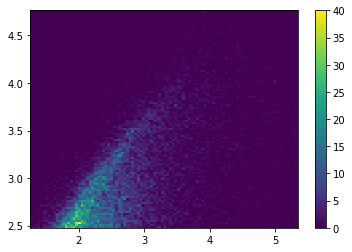

In [8]:
h = plt.hist2d(df_gammas['mc_energy'],df_gammas['intensity'],bins=100)
plt.colorbar(h[3])

<font size="4">
Let's choose events with a closer impact parameter (>40m, <100m)

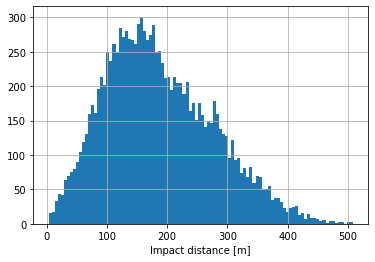

In [9]:
df_gammas['mc_core_distance'] = df_gammas['impact'] #Uncomment if you are using an old file without the "mc_core_distance key"
df_gammas.mc_core_distance.hist(bins=100);
plt.xlabel('Impact distance [m]');

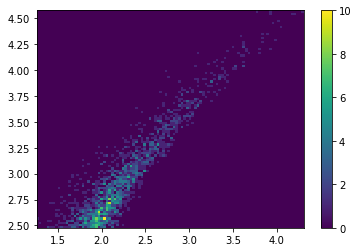

In [10]:
filter_impact = (df_gammas.mc_core_distance > 40) & (df_gammas.mc_core_distance < 100)
closer = df_gammas[filter_impact]
c = plt.hist2d(closer['mc_energy'],closer['intensity'],bins=100)
plt.colorbar(c[3]);

<font size="4">
Correlation is much more clear for this range. 
<br><br>
Let's see how this cut affect to the energy reconstruction.
<br><br>
First of all, let's train a Random Forest with all events, **without any cut** and without using any mc information.
<br>
Choose the features for training the random forest (Hillas and Timing parameters) 

In [11]:
features = ['intensity',                                                                                  
            'time_gradient',                                                                              
            'width',                                                                                      
            'length',                                                                                     
            'wl',                                                                                         
            'phi',                                                                                        
            'psi',
            'skewness',
            'kurtosis']

<font size="4">
Split data into train and test sets.

In [12]:
from sklearn.model_selection import train_test_split
np.random.seed(0)
train, test = train_test_split(df_gammas, train_size=0.8)
print("Training datasets: {} events \nTest dataset: {} events".format(len(train), len(test)))

Training datasets: 9683 events 
Test dataset: 2421 events


<font size="4">
And train Random Forests for Energy and Disp reconstruction.

In [13]:
from lstchain.io.config import get_standard_config
custom_config = get_standard_config()
custom_config['regression_features'] = features

RFreg_Energy, RFreg_Disp = dl1_to_dl2.train_reco(train,custom_config)

Given features:  ['intensity', 'time_gradient', 'width', 'length', 'wl', 'phi', 'psi', 'skewness', 'kurtosis']
Number of events for training:  9683
Training Random Forest Regressor for Energy Reconstruction...
Random Forest trained!
Training Random Forest Regressor for disp_norm Reconstruction...
Random Forest trained!
Done!


<font size="4">
Apply RF to test data to reconstruct Energy.

Feature importances (gini index)
1. intensity (0.403711)
2. skewness (0.244341)
3. time_gradient (0.134707)
4. length (0.074602)
5. kurtosis (0.043110)
6. wl (0.037891)
7. width (0.025218)
8. psi (0.019826)
9. phi (0.016593)


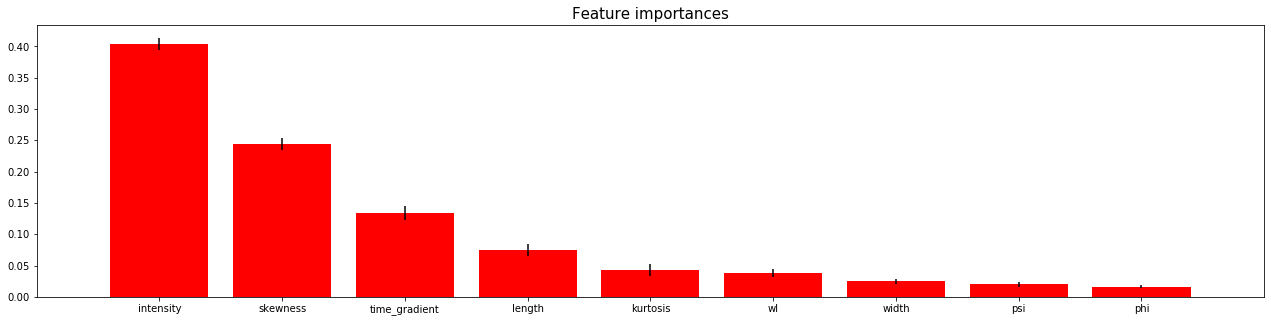

In [14]:
from lstchain.visualization.plot_dl2 import plot_importances
plt.figure(figsize=(22,5))
plot_importances(RFreg_Energy, features);

In [15]:
test['reco_energy'] = RFreg_Energy.predict(test[features])

/Users/garciaenrique/anaconda3/envs/cta-dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


-0.00273987640278246 0.5723908670962217
28 27.474974067162062 27.003880780470187
-0.00273987640278246 0.43770893316385173


(-0.00273987640278246, 0.43770893316385173)

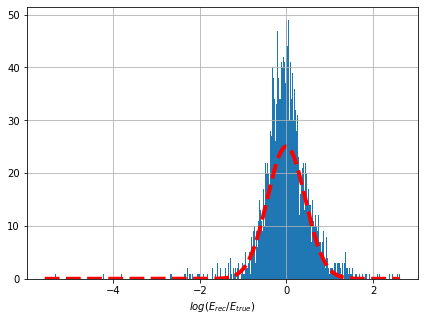

In [16]:
plt.figure(figsize=(7,5))
plt.grid()
#plot_dl2.plot_e(test,True)
calc_resolution(test)

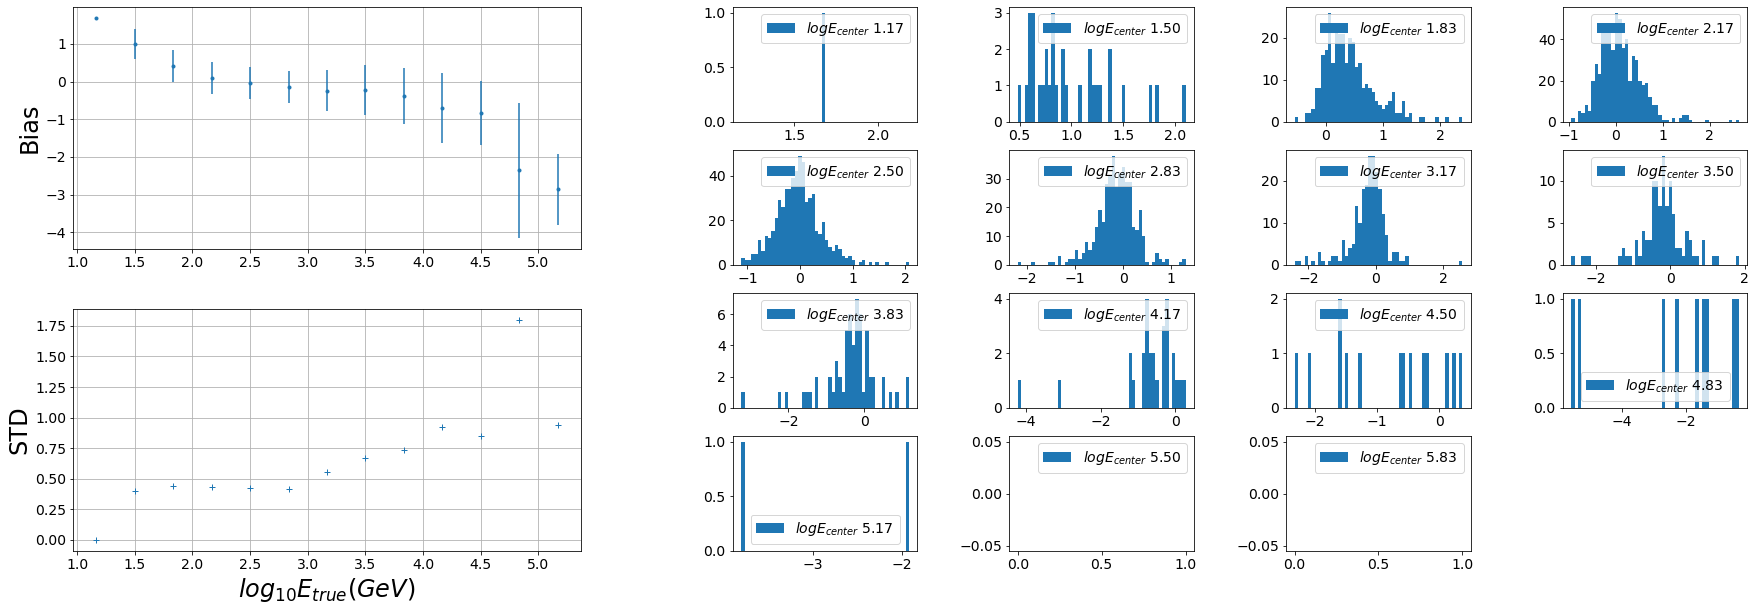

In [17]:
plot_e_resolution(test,15)

<font size="4">
    Now, lets do the cuts on impact parameter to have closer events.

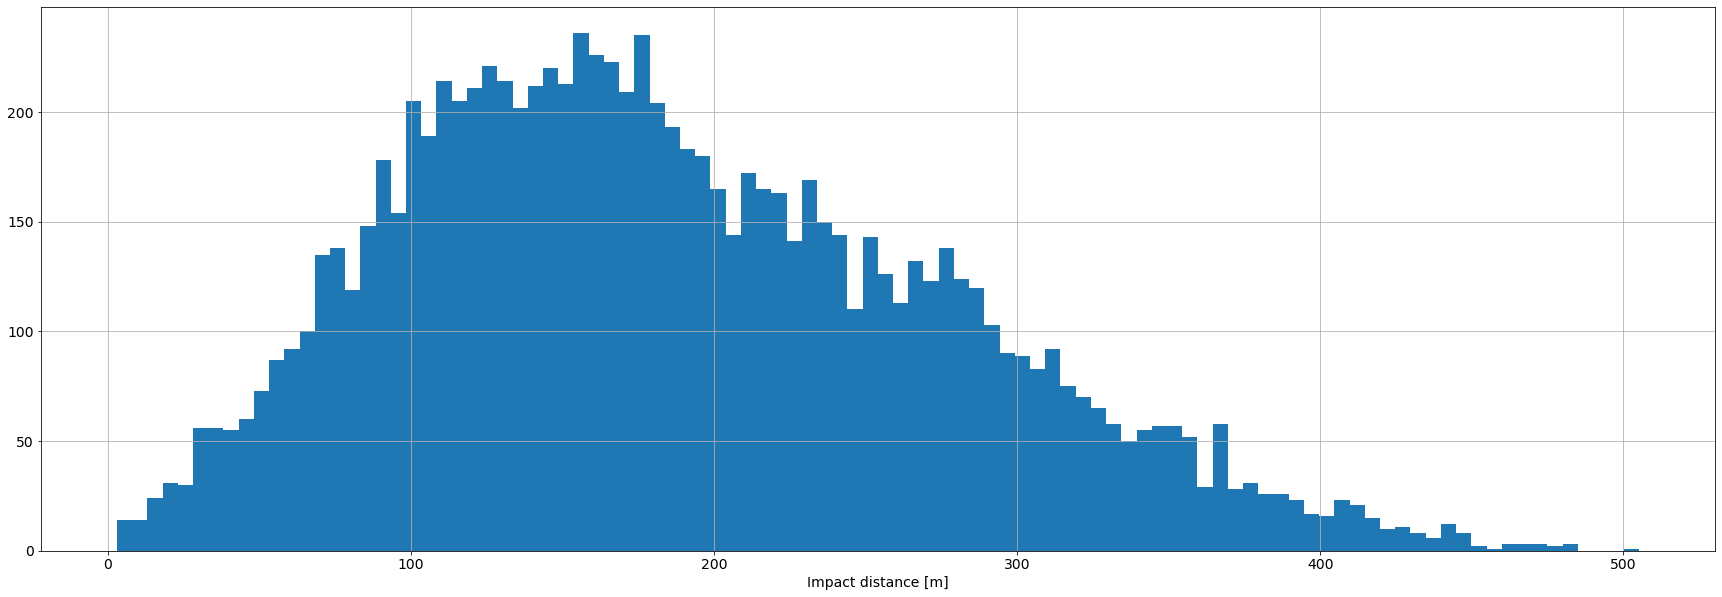

In [18]:
train.mc_core_distance.hist(bins=100);
plt.xlabel('Impact distance [m]');

In [19]:
train_cut = train[(train.mc_core_distance>40) & (train.mc_core_distance<200)]
test_cut = test[(test.mc_core_distance>40) & (test.mc_core_distance<200)]

<font size="4">
    Train the RF again.

In [20]:
RFreg_Energy, RFreg_Disp = dl1_to_dl2.train_reco(train_cut, custom_config)

Given features:  ['intensity', 'time_gradient', 'width', 'length', 'wl', 'phi', 'psi', 'skewness', 'kurtosis']
Number of events for training:  5546
Training Random Forest Regressor for Energy Reconstruction...
Random Forest trained!
Training Random Forest Regressor for disp_norm Reconstruction...
Random Forest trained!
Done!


Feature importances (gini index)
1. intensity (0.870297)
2. time_gradient (0.029438)
3. skewness (0.019631)
4. psi (0.014398)
5. kurtosis (0.014120)
6. width (0.013922)
7. length (0.013680)
8. wl (0.012567)
9. phi (0.011948)


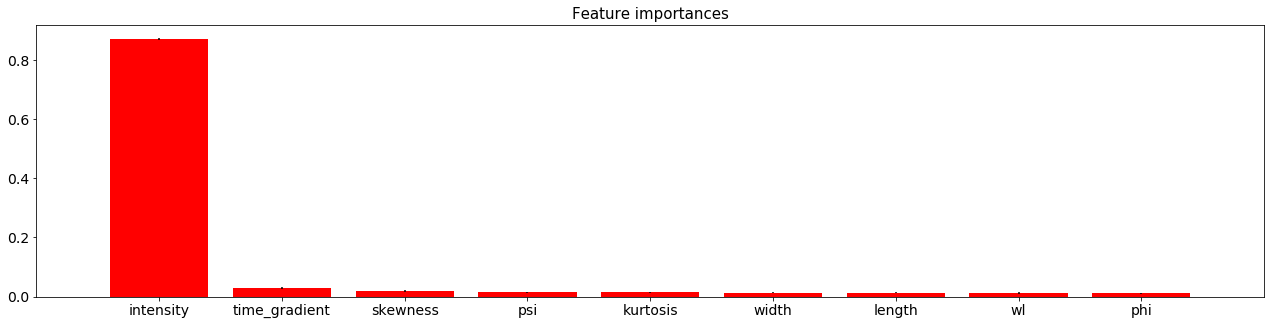

In [21]:
plt.figure(figsize=(22,5))
plot_importances(RFreg_Energy, features);

<font size="4">
    And reconstruct the energy.

In [22]:
test_cut['reco_energy'] = RFreg_Energy.predict(test_cut[features])

/Users/garciaenrique/anaconda3/envs/cta-dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


-0.007815518393407455 0.3658399639109474
55 6.165240098541984 6.148507714140931
-0.007815518393407455 0.3426903061453519


(-0.007815518393407455, 0.3426903061453519)

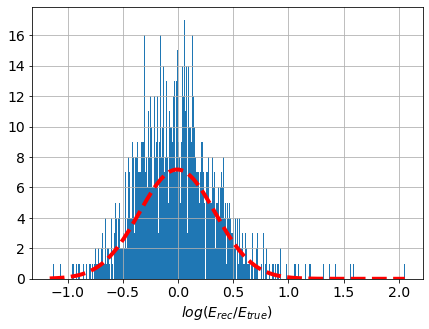

In [23]:
plt.figure(figsize=(7,5))
plt.grid()
#plot_dl2.plot_e(test_cut,True)
calc_resolution(test_cut)

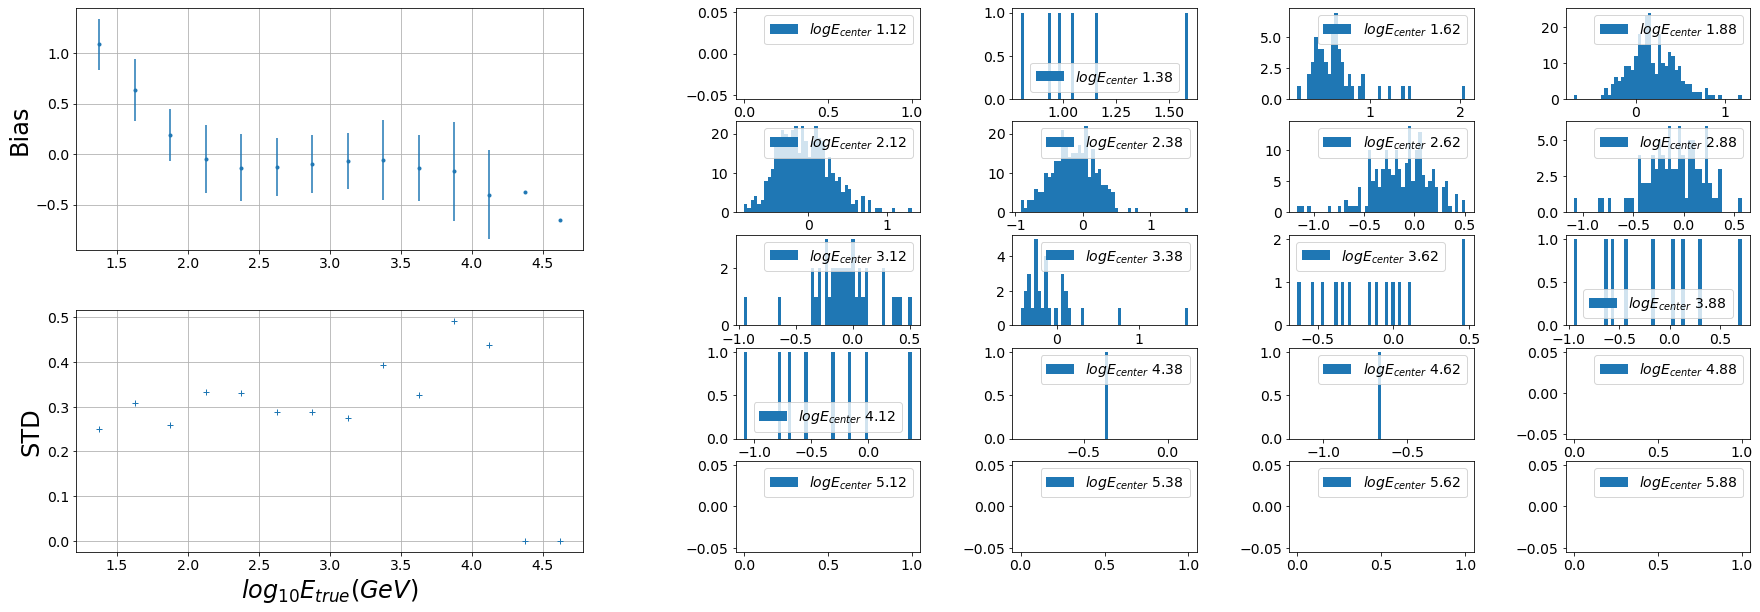

In [24]:
plot_e_resolution(test_cut,20)

<font size="4">
    Let's do a last test. We will use all events, but using the impact parameter as a feature.

In [25]:
features = ['intensity',                                                                                  
            'time_gradient',                                                                              
            'width',                                                                                      
            'length',                                                                                     
            'wl',                                                                                         
            'phi',                                                                                        
            'psi',
            'skewness',
            'kurtosis',
            'mc_core_distance']

custom_config['regression_features'] = features

<font size="4">
And train Random Forests for Energy and Disp reconstruction.

In [26]:
RFreg_Energy, RFreg_Disp = dl1_to_dl2.train_reco(train,custom_config)

Given features:  ['intensity', 'time_gradient', 'width', 'length', 'wl', 'phi', 'psi', 'skewness', 'kurtosis', 'mc_core_distance']
Number of events for training:  9683
Training Random Forest Regressor for Energy Reconstruction...
Random Forest trained!
Training Random Forest Regressor for disp_norm Reconstruction...
Random Forest trained!
Done!


Feature importances (gini index)
1. intensity (0.443297)
2. mc_core_distance (0.424355)
3. skewness (0.057328)
4. wl (0.022012)
5. length (0.015750)
6. kurtosis (0.009861)
7. phi (0.009326)
8. psi (0.007694)
9. width (0.005406)
10. time_gradient (0.004969)


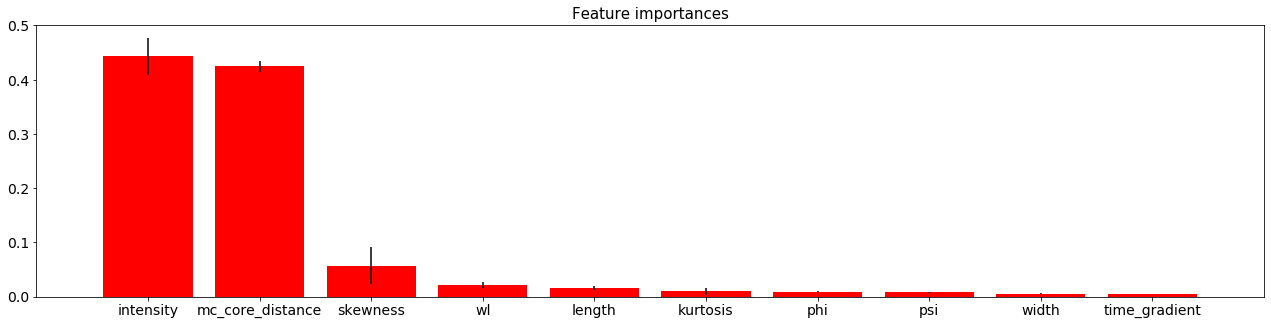

In [27]:
plt.figure(figsize=(22,5))
plot_importances(RFreg_Energy, features);

<font size="4">
Apply RF to test data to reconstruct Energy.

/Users/garciaenrique/anaconda3/envs/cta-dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


-0.006847706834342981 0.31655786439959555
29 16.277286936463565 15.96958995099001
-0.006847706834342981 0.2669369367047296


(-0.006847706834342981, 0.2669369367047296)

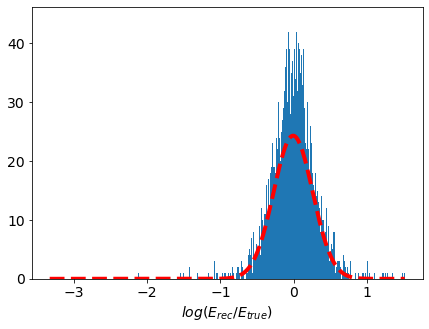

In [28]:
test['reco_energy'] = RFreg_Energy.predict(test[features])
plt.figure(figsize=(7,5))
#plot_dl2.plot_e(test,True)
calc_resolution(test)
#plt.savefig("gaussian_fit.png")

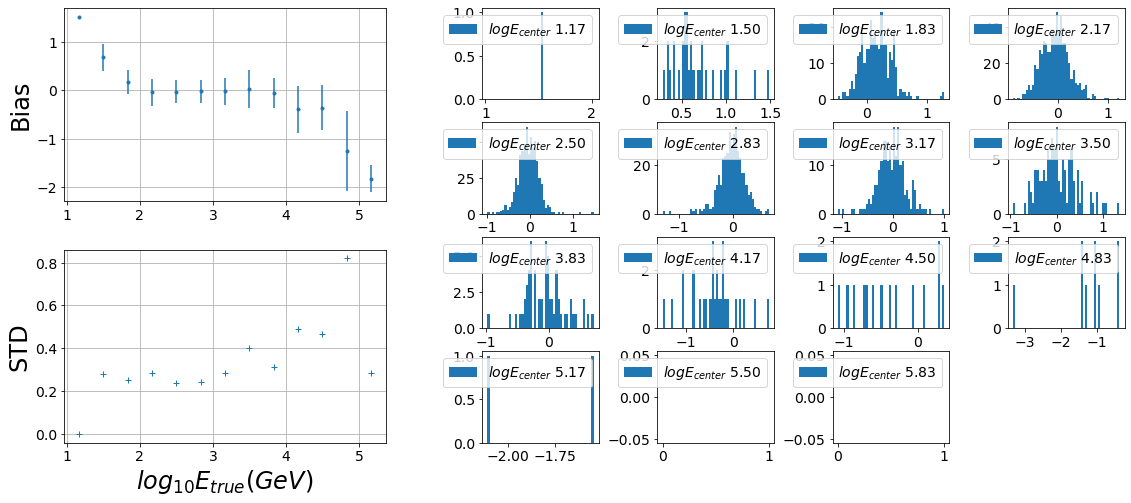

In [29]:
plt.figure(figsize=(19,8))
plot_e_resolution(test,15)